In [1]:
import os
os.chdir('d:\\code\\ectools')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
from ef.tools import TicToc

ldir = os.listdir('data')
fpath = '.\\data\\'
fname = ldir[3]
#print(ldir)
print(fpath + fname)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'd:\\code\\ectools'

In [32]:
# Parent electrochemistry file class

class ElectroChemistry():
    ''' The default container and parent class for containing electrochemistry files and methods
    '''

    # Class variables and constants
    identifiers = set()
    get_columns = {'redherring': (r'redherring',), 'time': (r'time/.?s',), 'pot': (r'Ewe/.?V', r'potential',), 'curr':(r'<?I>?/.?A',)}# Data columns to be imported. Keys will become instance attributes so must adhere to a strict naming scheme. The values should be list-like to support multiple different regex identifiers, which are used in a re.search.    

    # Initialize
    def __init__(self, fname, fpath, **kwargs):
        ''' Create a generalized ElecroChemistry object'''
        self.fname = fname # Filename
        self.fpath = fpath # Path to file
        for key, val in kwargs.items():
            setattr(self, key, val)
    def __getitem__(self, key):
        '''Makes object subscriptable like a dict'''
        return self.__getattribute__(key)
    def __setitem__(self, key, value):
        '''M'''
        self.__setattr__(key, value)

    # Class methods
    def parse_meta_mpt(self):
        '''Parse attributes from the metadata block'''
        #self.colon_delimited = [row.split(':') for row in self.meta]
        meta_width = [[row[:20].strip(), row[20:].strip()] for row in self.meta] # The part of the meta block we want is width delimited
        meta_width_new = []
        for row in meta_width:
            if len(row) > 1 and len(row[0]) < 19 and len(row[1]):
                if row[0] == 'vs.':
                    meta_width_new[-1] += row
                else:
                    m = re.search(r'\((.?\w)\)', row[0])
                    if m:
                        meta_width_new.append([row[0][:m.start(0)].strip(), row[1], m.group(1)])
                    else:
                        meta_width_new.append(row)
        self.meta_width = meta_width_new
        self.meta_dict = {row[0]: row[1:] for row in meta_width_new} # If the experiment was modified during run, the last value will be entered


In [33]:
# CyclicVoltammetry Class
class CyclicVoltammetry(ElectroChemistry):
    '''Cyclic voltammetry file container'''

    # Class variables and constants
    identifiers = {'Cyclic Voltammetry'} # Strings in the raw files which indicate the technique
    get_columns = {'redherring': (r'redherring',), 'oxred': (r'ox/red',), 'time': (r'time/.?s',), 'curr': (r'<?I>?/.?A',), 'pot': (r'Ewe/.?V', r'potential',), 'cycle': (r'cycle number',)} # Data columns to be imported. Keys will become instance attributes so must adhere to a strict naming scheme. The values should be list-like to support multiple different regex identifiers, which are used in a re.search.
    # Initialize

    def __init__(self, *args, **kwargs):
        '''Create a Cyclic Voltammetry container'''
        super().__init__(*args, **kwargs)

    # Class methods
    def parse_meta_mpt(self):
        '''Parse the metadata blocks into attributes'''
        super().parse_meta_mpt() # Preprocess the metadata block
        self.scanrate = nunit(float(self.meta_dict['dE/dt'][0]), self.meta_dict['dE/dt unit'][0])
        self.pot_init = nunit(float(self.meta_dict['Ei'][0]), self.meta_dict['Ei'][1], self.meta_dict['Ei'][3])
        self.pot_upper = nunit(float(self.meta_dict['E1'][0]), self.meta_dict['E1'][1])
        self.pot_lower = nunit(float(self.meta_dict['E2'][0]), self.meta_dict['E2'][1])
        self.pot_end = nunit(float(self.meta_dict['Ef'][0]), self.meta_dict['Ef'][1], self.meta_dict['Ef'][3])
        self.ncycles = int(self.meta_dict['nc cycles'][0])

In [34]:
# ECList class
class ECList(list):
    '''List container class for electrochemistry files'''
    
    def __init__(self, fpath=None):
        self.fpath = fpath
        super().__init__(self)


In [35]:
class nunit():
    '''Collects values and units'''
    si_base = {'n': 1e-9, 'µ': 1e-6, 'm': 1e-3, 'k': 1e3}
    def __init__(self, value, unit, vs=None):
        assert (type(value) is float or type(value) is int)
        self.value = value
        self.unit = unit
        if vs:
            self.vs = vs
    def __repr__(self):
        if self.vs:
            return f'{self.value} {self.unit} vs. {self.vs}'
        return f'{self.value} {self.unit}'
    

def get_class(ident) -> ElectroChemistry:
    '''Tries to match the identifier with the container classes available.'''
    for child in ElectroChemistry.__subclasses__():
        if ident in child.identifiers:
            return child
    return ElectroChemistry

def load_file(fname, fpath):
    '''Load and parse an electrochemistry file'''
    try:
        
        with open(fpath + fname) as f:
            row_1 = f.readline().strip()
            if re.match('EC-Lab ASCII FILE', row_1):
                return parse_mpt(fname, fpath)
    except Exception as E:
        print('ectools.load_file error:')
        raise E

def parse_mpt(fname, fpath):
    try:
        meta_list = []
        with open(fpath + fname) as f: # Open the file to read the first lines
            meta_list.append(f.readline().strip()) # EC-Lab
            meta_list.append(f.readline().strip()) # Contains the number of lines in the metadata block
            head_row = int(re.findall('\d\d', meta_list[1])[0]) -1 # Header row
            for i in range(2, head_row+1):
                meta_list.append(f.readline().strip()) # Read the rest of the metadata block
        technique = meta_list[3] # The fourth line of the block should contain the EC-Lab technique used
        container_class = get_class(technique) # Match the technique to the container classes
        container = container_class(fname, fpath) # Initialize the container

        try: 
            # OPTIONAL: A function named fname_parser may be supplied to read information from the filename into the container. 
            # It should return a dictionary from which all key:value pairs are imported as instance attributes in the container
            fname_dict = fname_parser(fname)
            assert type(fname_dict) is dict
            for key, val in fname_dict.items():
                container[key] = val
        except:
            pass
                
        headers = meta_list[-1].split('\t') # Isolate header row

        coln = {}
        # Match the columns the container class expects with the columns in the header. Need to maintain order as usecols does not!
        for i, colh in enumerate(headers):
            for key, id_tuple in container.get_columns.items():
                for id_rgx in id_tuple:
                    if re.match(id_rgx, colh):
                        coln[key] = i
                        continue

        # Using pandas.read_csv because it is faster than any other csv data block importer methods i've tried AND it interprets data types
        df = pd.read_csv(fpath + fname, 
            encoding='ANSI', 
            sep='\t', 
            header=head_row, 
            skip_blank_lines=False, # ensures the head_row is correct
            index_col=False,
            usecols=coln.values() # ! order is not maintained
            )
        df.columns = coln.keys()
        for key in df.columns:
            container[key] = df[key].to_numpy()
        del(df)
        container.meta = meta_list
        container.parse_meta_mpt()
        return container
    except Exception as E:
        print('ectools.parse_mpt error:')
        raise E
    return 


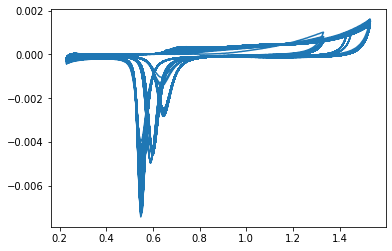

In [37]:
f = load_file(fname, fpath)
plt.plot(f['pot'], f.curr)
plt.show()

In [303]:
f.meta_dict

{'Ei': ['0.000', 'V', 'vs.', 'Eoc'],
 'dE/dt': ['500.000'],
 'dE/dt unit': ['mV/s'],
 'E1': ['1.330', 'V'],
 'Step percent': ['100'],
 'N': ['64'],
 'E range min': ['-2.500', 'V'],
 'E range max': ['2.500', 'V'],
 'I Range': ['10 µA'],
 'I Range min': ['Unset'],
 'I Range max': ['Unset'],
 'I Range init': ['Unset'],
 'Bandwidth': ['5'],
 'E2': ['0.230', 'V', 'vs.', 'Ref'],
 'nc cycles': ['200'],
 'Reverse Scan': ['1'],
 'Ef': ['0.400', 'V', 'vs.', 'Ref']}

In [281]:
from collections import namedtuple
t = namedtuple('val_unit', 'value unit vs')
t1 = t(0.1, 'V')

TypeError: __new__() missing 1 required positional argument: 'vs'

In [3]:
float('600.00')

600.0

In [ ]:
# base
t = TicToc()
t.tic()
meta_list = []
with open(testfile) as f:
    meta_list.append(f.readline())
    if not re.match('EC-Lab ASCII FILE', meta_list[0]):
        raise Exception
    meta_list.append(f.readline())
    head_row = int(re.findall('\d\d', meta_list[1])[0]) -1
    for i in range(2, head_row+1):
        meta_list.append(f.readline())
    head = meta_list[-1].split('\t')
    time = []
    curr = []
    pot = []
    cycle = []
    cols_re = ('time\/.?s', 'Ewe\/.?V', '<?I>?\/.?A', 'cycle number')
    coln = tuple(head.index(list(filter(re.compile(col_re).match, head))[0]) for col_re in cols_re)
    data = [time, pot, curr, cycle]
    while True:
        row = f.readline().split('\t')
        if len(row) == 1:
            print(row)
            break
        for i, col in enumerate(coln):
            data[i].append(float(row[col]))
print(len(data[0]))
t.toc()
plt.plot(time, pot)
plt.show()

In [ ]:
# csv
tt = TicToc()
import csv
tt.tic()
file_list = list(csv.reader(open(testfile, 'r'), delimiter='\t'))
head_row = int(re.findall('\d\d', file_list[1][0])[0]) - 1
head = file_list[head_row]
data_list = file_list[head_row + 1 :]
meta_list = file_list[:head_row]
t_coln = head.index('time/s')
t = [float(row[t_coln]) for row in data_list]
e_coln = head.index('Ewe/V')
e = [float(row[e_coln]) for row in data_list]
tt.toc()
plt.plot(t, e)
plt.show()


In [ ]:
# csv DictReader
import csv
t=TicToc()
t.tic()
meta_list = []
with open(testfile) as f:
    meta_list.append(f.readline())
    if not re.match('EC-Lab ASCII FILE', meta_list[0]):
        raise Exception
    meta_list.append(f.readline())
    head_row = int(re.findall('\d\d', meta_list[1])[0]) -1
    for i in range(2, head_row+1):
        meta_list.append(f.readline())
    head = meta_list[-1].split('\t')
    cols = ('time/s', 'Ewe/V', '<I>/mA', 'cycle number')
    data_dict = {h: [] for h in cols}
    cols_re = ('time\/.?s', 'Ewe\/.?V', '<?I>?\/.?A', 'cycle number')
    reader = csv.DictReader(f, delimiter='\t', fieldnames=head)
    for row in reader:
        for key in data_dict:
            data_dict[key].append(float(row[key]))
t.toc()
plt.plot(data_dict['time/s'], data_dict['Ewe/V'])
plt.show()



In [ ]:
print('<I>/mA')
data_dict['<I>/mA']

In [ ]:
np.__version__

In [ ]:
# Numpy in dict
t = TicToc()
t.tic()
dd = dict()
dd['meta_list'] = []
with open(testfile) as f:
    dd['meta_list'].append(f.readline())
    if not re.match('EC-Lab ASCII FILE', dd['meta_list'][0]):
        raise Exception
    dd['meta_list'].append(f.readline())
    dd['head_row'] = int(re.findall('\d\d', dd['meta_list'][1])[0]) -1
    for i in range(2, dd['head_row']+1):
        dd['meta_list'].append(f.readline())

dd['head'] = dd['meta_list'][-1].split('\t')
cols_to_import = {'time': r'time/.?s', 'pot': r'Ewe/.?V', 'curr': r'<?I>?/.?A', 'cycle': r'cycle number'}
coln = tuple(dd['head'].index(list(filter(re.compile(col_re).match, dd['head']))[0]) for col_re in cols_to_import.values())
t.toc(keep=True)
f = np.loadtxt(testfile, delimiter='\t', skiprows=dd['head_row']+1, usecols=coln)
t.toc(keep=True)
dd['time'] = f[:, 0]
dd['pot'] = f[:, 1]
dd['curr'] = f[:, 2]
dd['cycle'] = f[:, 3]
t.toc()
plt.plot(dd['time'], dd['pot'])
plt.show()

In [ ]:
dd['time']

In [ ]:
# Pandas
t=TicToc()
t.tic()
meta_list = []
with open(testfile) as f:
    meta_list.append(f.readline())
    if not re.match('EC-Lab ASCII FILE', meta_list[0]):
        raise Exception
    meta_list.append(f.readline())
    head_row = int(re.findall('\d\d', meta_list[1])[0]) -1
    for i in range(2, head_row+1):
        meta_list.append(f.readline())
    head = meta_list[-1].split('\t')
cols_to_import = {'time': r'time/.?s', 'pot': r'Ewe/.?V', 'curr': r'<?I>?/.?A', 'cycle': r'cycle number'}
cols_re = ('time\/.?s', 'Ewe\/.?V', '<?I>?\/.?A', 'cycle number')
coln = tuple(head.index(list(filter(re.compile(col_re).match, head))[0]) for col_re in cols_to_import.values())
df = pd.read_csv(testfile, 
    encoding='ANSI', 
    sep='\t', 
    header=head_row, 
    skip_blank_lines=False,
    index_col=False,
    usecols=coln
    )
df.columns = ['time', 'pot', 'cur', 'cyc']
print(df.head())
t.toc()
plt.plot(df.time, df.pot)
plt.show()

In [ ]:
import timeit

np_cur = df.cur.to_numpy()
np_cyc = df.cyc.to_numpy()

%timeit df.cur[df.cyc==1]
%timeit df.cur.to_numpy()[df.cyc==1]
%timeit np_cur[np_cyc==1]

%timeit df.cur * 1000
%timeit np_cur * 1000

%timeit df.cur.to_numpy()

Numpy arrays seem to be an order of magnitude better than pandas series for indexing purposes!!!

In [ ]:
import timeit

coln = (5, 7, 8, 9)
head_row = 58

%timeit pd.read_csv(testfile, encoding='ANSI', sep='\t', header=head_row, skip_blank_lines=False, index_col=False, usecols=coln)
%timeit np.loadtxt(testfile, delimiter='\t', skiprows=head_row+1, usecols=coln)
